<a href="https://colab.research.google.com/github/UpEon/1st/blob/main/n223a_evaluation_metrics_for_classification_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [4]:
# pip install category-encoders

     |████████████████████████████████| 82 kB 217 kB/s 


In [149]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [154]:
# 이번에는 타겟으로 계절독감백신 접종여부를 사용하겠습니다.

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
# 테스트 데이터 수를 n=14052 로 한정합니다.
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [155]:
train = train.drop_duplicates()

In [156]:
from sklearn.model_selection import train_test_split

# 검증세트를 테스트세트와 크기와 같도록 만듭니다.
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((13744, 39), (28104, 39), (28104, 38))

In [157]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    colnames = selected_cols.columns.tolist()
    labels = selected_cols.nunique()
    
    selected_features = labels[labels <= 30].index.tolist()
    df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)

    # 결측치가 70% 이상 있는 column 제거
    dels_null = df.columns[df.isnull().mean() > 0.7]
    df.drop(columns=dels_null, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [158]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [159]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8154355251921435


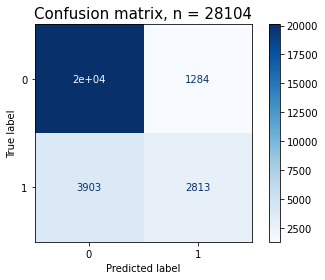

In [160]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [161]:
cm = pcm.confusion_matrix
cm

array([[20104,  1284],
       [ 3903,  2813]])

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **(Urclass Quiz) 다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [162]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

In [163]:
# 정밀도
positives = tp + fp
precision = tp/positives

In [164]:
# real positives
real_positives = tp + fn
real_positives

6372

In [165]:
# 재현율
recall = tp / real_positives

In [166]:
### 이곳에서 과제를 진행해 주세요 ### 
beta = 2.0
f1_beta = (1+beta**2)*((precision*recall)/((beta**2*precision)+recall))
f1_beta

0.7063126093178564

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(Urclass Quiz) 임계값을 증가시킬때 positive 범주의 재현율 변화 중 올바른 설명을 고르세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [167]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     21388
           1       0.69      0.42      0.52      6716

    accuracy                           0.82     28104
   macro avg       0.76      0.68      0.70     28104
weighted avg       0.80      0.82      0.80     28104



In [168]:
pipe.classes_

array([0, 1])

In [169]:
pipe.predict(X_val)

array([0, 0, 0, ..., 0, 0, 1])

In [170]:
pipe.predict_proba(X_val)

array([[0.94 , 0.06 ],
       [0.91 , 0.09 ],
       [0.93 , 0.07 ],
       ...,
       [0.955, 0.045],
       [0.71 , 0.29 ],
       [0.4  , 0.6  ]])

In [171]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.06 , 0.09 , 0.07 , ..., 0.045, 0.29 , 0.6  ])

In [172]:
import seaborn as sns

False    24007
True      4097
dtype: int64

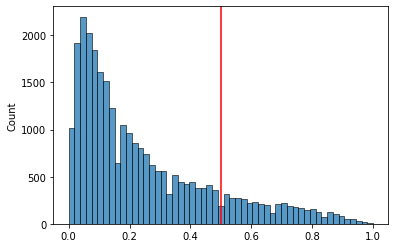

In [173]:
# Randomforestclassifier 기본 임계값은 0.5입니다.
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [174]:
from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

#임계값이 증가할 수록 감소한다.

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(Urclass Quiz) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [175]:
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=10, max_depth=None, oob_score=True)
)

In [176]:
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred2))

검증 정확도:  0.8189225732991745


In [128]:
pipe2.classes_

array([0, 1])

In [129]:
pipe2.predict(X_val)

array([0, 0, 1, ..., 0, 0, 0])

In [130]:
pipe2.predict_proba(X_val)

array([[0.70118333, 0.29881667],
       [0.725     , 0.275     ],
       [0.31244643, 0.68755357],
       ...,
       [0.912     , 0.088     ],
       [0.873     , 0.127     ],
       [0.74006905, 0.25993095]])

In [177]:
# 백신접종 확률
y_pred_proba2 = pipe2.predict_proba(X_val)[:, 1]
y_pred_proba2

array([0.081     , 0.099     , 0.05666667, ..., 0.067     , 0.335     ,
       0.67658333])

In [178]:
def explore_threshold2(y_true, y_pred_proba2, threshold=0.5):
    y_pred2 = y_pred_proba2 >= threshold
    vc = pd.Series(y_pred2).value_counts()
    ax = sns.histplot(y_pred_proba2, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred2))

    
interact(explore_threshold2, 
    y_true=fixed(y_val), 
    y_pred_proba2=fixed(y_pred_proba2), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
### 이곳에서 과제를 진행해 주세요 ###

# 다양해진다

In [179]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba2)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.995500
1,0.000047,0.000149,0.995500
2,0.000140,0.000447,0.984533
3,0.000187,0.000596,0.983633
4,0.000234,0.000596,0.980000
...,...,...,...
3479,0.999205,0.999851,0.003250
3480,0.999579,0.999851,0.003000
3481,0.999813,0.999851,0.002000
3482,1.000000,0.999851,0.001000


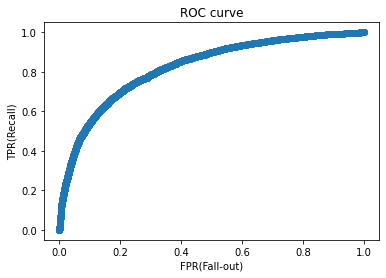

In [180]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [181]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 2248 , threshold: 0.2718333333333333


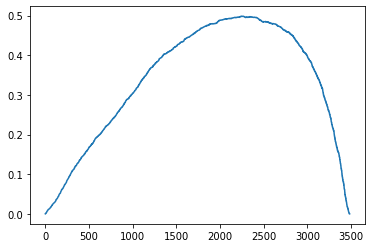

In [182]:
plt.plot(tpr-fpr);

In [183]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84     21388
           1       0.51      0.71      0.59      6716

    accuracy                           0.77     28104
   macro avg       0.70      0.75      0.71     28104
weighted avg       0.80      0.77      0.78     28104



In [184]:
y_pred_05 = y_pred_proba >= 0.5
print(classification_report(y_val, y_pred_05))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     21388
           1       0.68      0.43      0.53      6716

    accuracy                           0.82     28104
   macro avg       0.76      0.68      0.71     28104
weighted avg       0.80      0.82      0.80     28104



In [185]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba2)
auc_score

0.8236780582711686

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **(Urclass Quiz) 캐글 Leaderboard의 본인 Score를 제출하세요.**

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


검증 정확도:  0.8154355251921435
f1_score : 0.520299639323037
AUC score: 0.7790197753567679


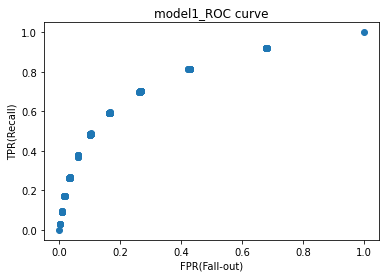

In [186]:
# model_1

from sklearn.metrics import f1_score

pipe_m1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=10, max_depth=None, oob_score=True, criterion='entropy')
)

pipe_m1.fit(X_train, y_train)
y_pred_m1 = pipe.predict(X_val)
y_pred_proba_m1 = pipe_m1.predict_proba(X_val)[:,1]
f1_m1 = f1_score(y_val, y_pred_m1)

print('검증 정확도: ', accuracy_score(y_val, y_pred_m1))
print('f1_score :', f1_m1)

fpr_m1, tpr_m1, thresholds_m1 = roc_curve(y_val, y_pred_proba_m1)

plt.scatter(fpr_m1, tpr_m1)
plt.title('model1_ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_m1 = roc_auc_score(y_val, y_pred_proba_m1)
print(f'AUC score: {auc_score_m1}')

In [187]:
optimal_idx_m1 = np.argmax(tpr_m1 - fpr_m1)
optimal_threshold_m1 = thresholds_m1[optimal_idx_m1]

y_pred_optimal_m1 = y_pred_proba >= optimal_threshold_m1

print(y_pred_optimal_m1)
print('model1\'s F1 score', f1_score(y_pred_optimal_m1, y_pred, average=None)[1])

[False False False ... False  True  True]
model1's F1 score 0.5493061607561842


검증 정확도:  0.8154355251921435
f1_score : 0.520299639323037
AUC score: 0.8188490672576331


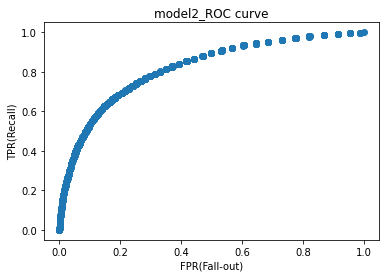

In [188]:
# model_2

from sklearn.metrics import f1_score

pipe_m2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10, max_depth=None, oob_score=True)
)

pipe_m2.fit(X_train, y_train)
y_pred_m2 = pipe.predict(X_val)
y_pred_proba_m2 = pipe_m2.predict_proba(X_val)[:,1]
f1_m2 = f1_score(y_val, y_pred_m2)

print('검증 정확도: ', accuracy_score(y_val, y_pred_m2))
print('f1_score :', f1_m2)

fpr_m2, tpr_m2, thresholds_m2 = roc_curve(y_val, y_pred_proba_m2)

plt.scatter(fpr_m2, tpr_m2)
plt.title('model2_ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_m2 = roc_auc_score(y_val, y_pred_proba_m2)
print(f'AUC score: {auc_score_m2}')

In [189]:
optimal_idx_m2 = np.argmax(tpr_m2 - fpr_m2)
optimal_threshold_m2 = thresholds_m2[optimal_idx_m2]

y_pred_optimal_m2 = y_pred_proba >= optimal_threshold_m2

print(y_pred_optimal_m2)
print('model2\'s F1 score', f1_score(y_pred_optimal_m2, y_pred, average=None)[1])

[False False False ... False False  True]
model2's F1 score 0.6368228802362633


In [190]:
### 이곳에서 과제를 진행해 주세요 ### 

submission = pd.DataFrame({'vacc_h1n1_f':y_pred_optimal_m2})
submission = pd.DataFrame({'id':submission.index,'vacc_h1n1_f':y_pred_optimal_m2})

submission.to_csv('submission-223.csv',index=False) 

# 0.26829

## 🔥 도전과제(Github - Discussion)

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 